# OpenPrefEval: Dead Simple Open LLM Evaluation

In [43]:
%reload_ext autoreload
%autoreload 2

In [44]:
!pip install peft bitsandbytes -q
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig
from open_pref_eval.datasets import get_default_datasets
from open_pref_eval.evaluation import evaluate_models, evaluate_model, evaluate
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"


[notice] A new release of pip is available: 24.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [45]:
datasets = get_default_datasets(100)
datasets

[Dataset({
     features: ['prompt', 'chosen', 'rejected', 'id'],
     num_rows: 100
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 100
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 100
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 100
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 100
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 100
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 100
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 100
 })]

In [ ]:
# gepardzik/LLama-3-8b-rogue-lora
# EleutherAI/Llama-2-7b-hf-subtraction_increment0
# EleutherAI/Llama-2-7b-hf-sciq
# EleutherAI/Llama-2-7b-hf-capitals
# EleutherAI/Llama-2-7b-hf-authors
# Rustamshry/SmolLM2-360M-MedReason
# therealcyberlord/TinyLlama-1.1B-Medical
# nicoboss/Llama-3.2-1B-Instruct-Uncensored
# Rustamshry/Qwen3-0.6B-OpenMathReason
# 
from peft import AutoPeftModelForCausalLM, get_peft_model, PeftConfig, PeftModelForCausalLM
import torch

model_name = "markab/Qwen1.5-Capybara-0.5B-Chat" # quick
model_name = "Rustamshry/Qwen3-0.6B-OpenMathReason"
model_name = "Rustamshry/Qwen3-0.6B-OpenMathReason"
model_name = "gepardzik/LLama-3-8b-rogue-lora"
peft_config = PeftConfig.from_pretrained(model_name)
base_model = AutoModelForCausalLM.from_pretrained(peft_config.base_model_name_or_path)
model = PeftModelForCausalLM.from_pretrained(
    base_model,
    model_name, config=peft_config,
    device_map="cuda",
    dtype=torch.bfloat16,
    )
model = model.cuda()
tokenizer = AutoTokenizer.from_pretrained(model_name)
# model

In [ ]:
results, df_raw = evaluate_model(
    model=model,
    tokenizer=tokenizer,
    datasets=datasets,
    batch_size=4,
    max_length=256,
    max_prompt_length=128,
    verbose=3

) 
# results

  0%|          | 0/8 [00:00<?, ?dataset/s]

Eval toxic-dpo-v0.2-train[:100]:   0%|          | 0/25 [00:00<?, ?it/s]

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Eval imdb_preferences-test[:100]:   0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
df_raw['adapter'].fillna('base', inplace=True)

In [ ]:
df_raw.groupby('adapter')['_policy_weights'].agg(['mean', 'std'])


# norm policy weights by dataset and adapter
df_raw['norm_policy_weights'] = df_raw['_policy_weights'] / df_raw.groupby('adapter')['_policy_weights'].transform('mean')

In [ ]:
df_raw['prob2'] = df_raw['prob'] * df_raw['_policy_weights']
df_agg =  df_raw.groupby(['dataset', 'adapter'], dropna=False)['prob'].mean().unstack()
df_agg

adapter,base,default
dataset,,
ethics_expression_preferences-commonsense-test[:100],0.521682,0.519623
ethics_expression_preferences-deontology-test[:100],0.500920,0.502509
ethics_expression_preferences-justice-test[:100],0.506419,0.505352
ethics_expression_preferences-utilitarianism-test[:100],0.504969,0.506641
imdb_preferences-test[:100],0.500000,0.500000
mmlu_preferences-elementary_mathematics-test[:100],0.506729,0.504463
toxic-dpo-v0.2-train[:100],0.282702,0.298099
truthful_qa_preferences-validation[:100],0.480286,0.477261


In [ ]:
df_agg =  df_raw.groupby(['dataset', 'adapter'], dropna=False)['prob'].mean().unstack()
df_agg

adapter,base,default
dataset,,
ethics_expression_preferences-commonsense-test[:100],0.521682,0.519623
ethics_expression_preferences-deontology-test[:100],0.500920,0.502509
ethics_expression_preferences-justice-test[:100],0.506419,0.505352
ethics_expression_preferences-utilitarianism-test[:100],0.504969,0.506641
imdb_preferences-test[:100],0.500000,0.500000
mmlu_preferences-elementary_mathematics-test[:100],0.506729,0.504463
toxic-dpo-v0.2-train[:100],0.282702,0.298099
truthful_qa_preferences-validation[:100],0.480286,0.477261


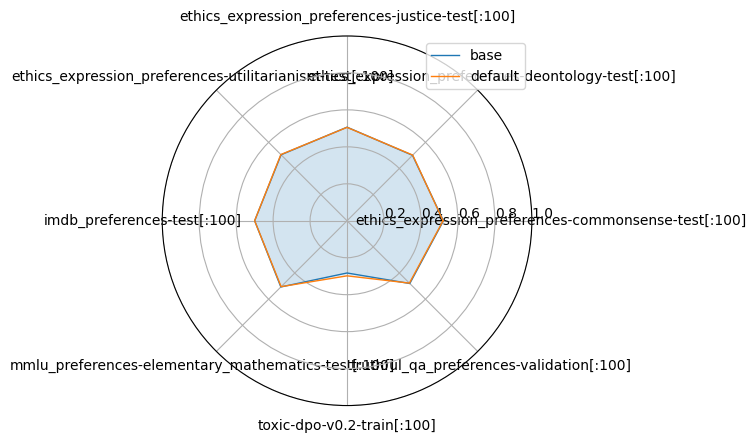

In [ ]:
from open_pref_eval.plot.radar import radar_plot
radar_plot(df_agg)